# Image Colorization

1. Adopt the implementation of the U-Net network from the previous task and train it on the task of image colorization.
2. Remove the skip connections of the implemented U-Net network, retrain it on the colorization task and examine the difference.

In [1]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_size)

        self.conv2 = nn.Conv2d(output_size, output_size, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_size)

        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 13):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.maxpool = nn.MaxPool2d((2, 2))

        self.conv = ConvBlock(512, 1024)

        # Decoder
        self.dconv_T1 = nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2, padding = 0), ConvBlock(512, 512))
        self.dconv_T2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0), ConvBlock(256, 256))
        self.dconv_T3 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0), ConvBlock(128, 128))
        self.dconv_T4 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0), ConvBlock(64, 64))

        self.output = nn.Conv2d(64, out_channels, kernel_size = 1, padding = 0)
        

    def forward(self, x):
        s1 = self.conv1(x)
        p1 = self.maxpool(s1)
        s2 = self.conv2(p1)
        p2 = self.maxpool(s2)
        s3 = self.conv3(p2)
        p3 = self.maxpool(s3)
        s4 = self.conv4(p3)
        p4 = self.maxpool(s4)

        b = self.conv(p4)

        d1 = self.dconv_T1(b)
        d2 = self.dconv_T2(d1)
        d3 = self.dconv_T3(d2)
        d4 = self.dconv_T4(d3)

        outputs = self.output(d4)
        return outputs

## Download the dataset from google drive:

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

# !unzip -q gdrive/MyDrive/data/landscapes.zip -d ./data/

Mounted at /content/gdrive


In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
!unzip -q landscapes.zip -d ./data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
From (redirected): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0&confirm=t&uuid=02eb96e8-9661-4aac-85ac-0dee5cad8e2e
To: /content/landscapes.zip
100% 650M/650M [00:13<00:00, 49.4MB/s]


## Colorization dataset

The dataset class loads the image and also converts them to a grayscale version. The image pair is then used for training.

In [3]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import numpy as np

class ColorizationDataset(Dataset):

    def __init__(self, train=True):
        self.all_images = sorted(glob.glob("./data/*"))
        self.images = self.all_images[:-500]
        self.test_images = self.all_images[-500:]
        if not train:
          self.images = self.test_images

        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        gray_image = np.array(gray_image).reshape((image.shape[0], image.shape[1], 1)).astype(np.float32) / 255.0

        image = np.transpose(image, (2, 0, 1))
        gray_image = np.transpose(gray_image, (2, 0, 1))
        return image, gray_image

    def __getitem__(self, idx):
        image, gray_image = self.transform_image(self.images[idx])
        sample = {'image': image, "gray_image": gray_image, 'idx': idx}

        return sample

## Examples of the training image pairs

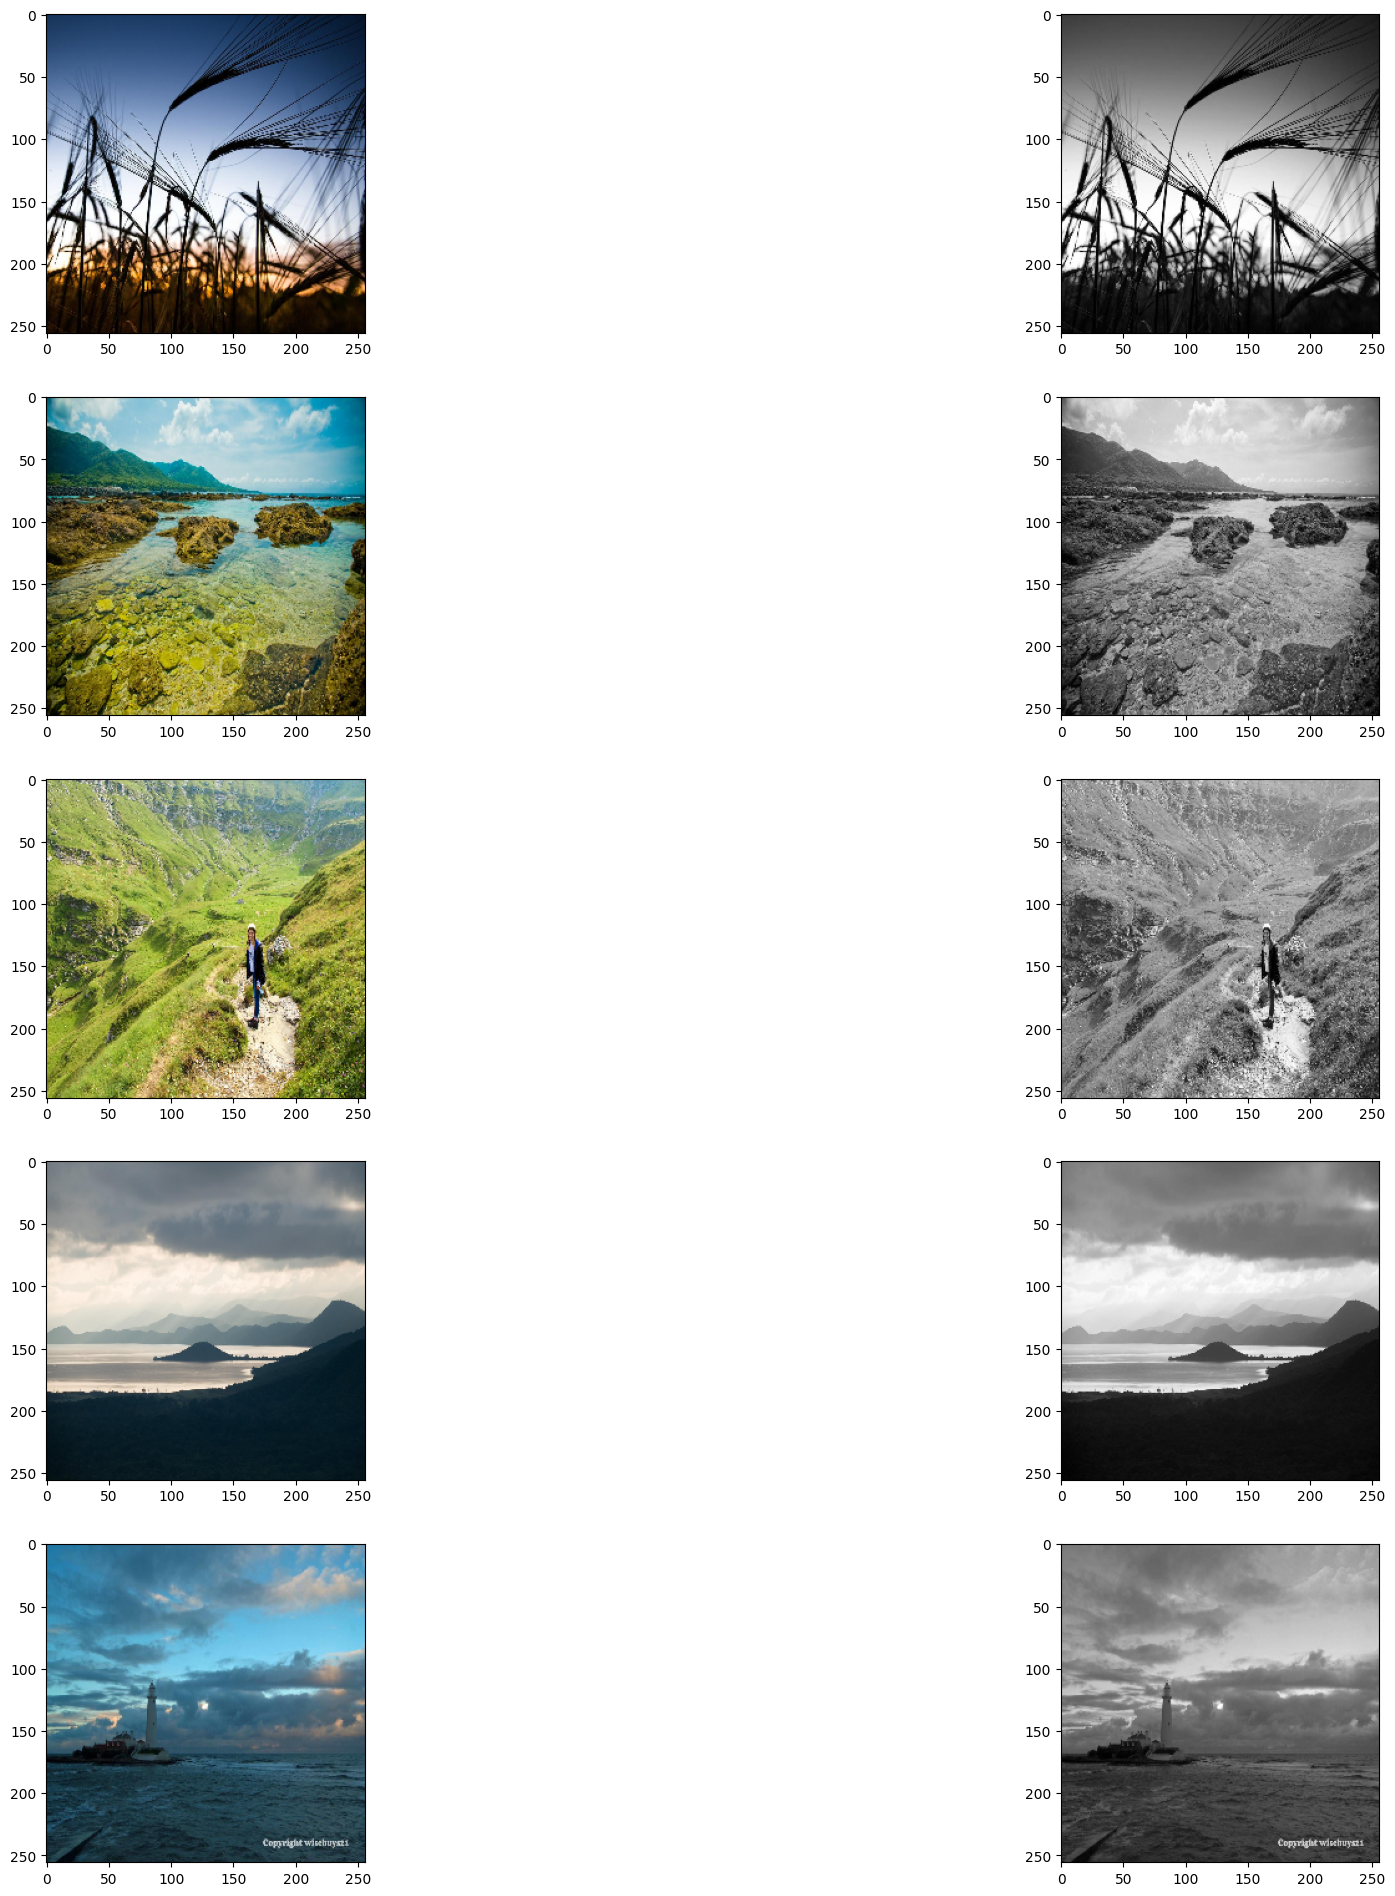

In [4]:
import matplotlib.pyplot as plt
trainset = ColorizationDataset(train=True)
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = batch['gray_image'][0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(gray,cmap='gray')
plt.show()


## Training loop


In [6]:
import torch
from tqdm.notebook import tqdm


trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


import torch.optim as optim

net = UNet(in_channels=1, out_channels=3)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs=5
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch+1)+"/"+str(epochs), unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs;
          gray_images = data["gray_image"]
          color_images = data["image"]

          # Get the inputs to the GPU
          gray_images = gray_images.cuda()
          color_images = color_images.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(gray_images)
          loss = nn.functional.l1_loss(outputs, color_images)
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
          prog_bar.update(4)


Epoch: 1/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 2/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 3/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 4/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 5/5:   0%|          | 0/3819 [00:00<?, ?img/s]

## Display output examples from the test set

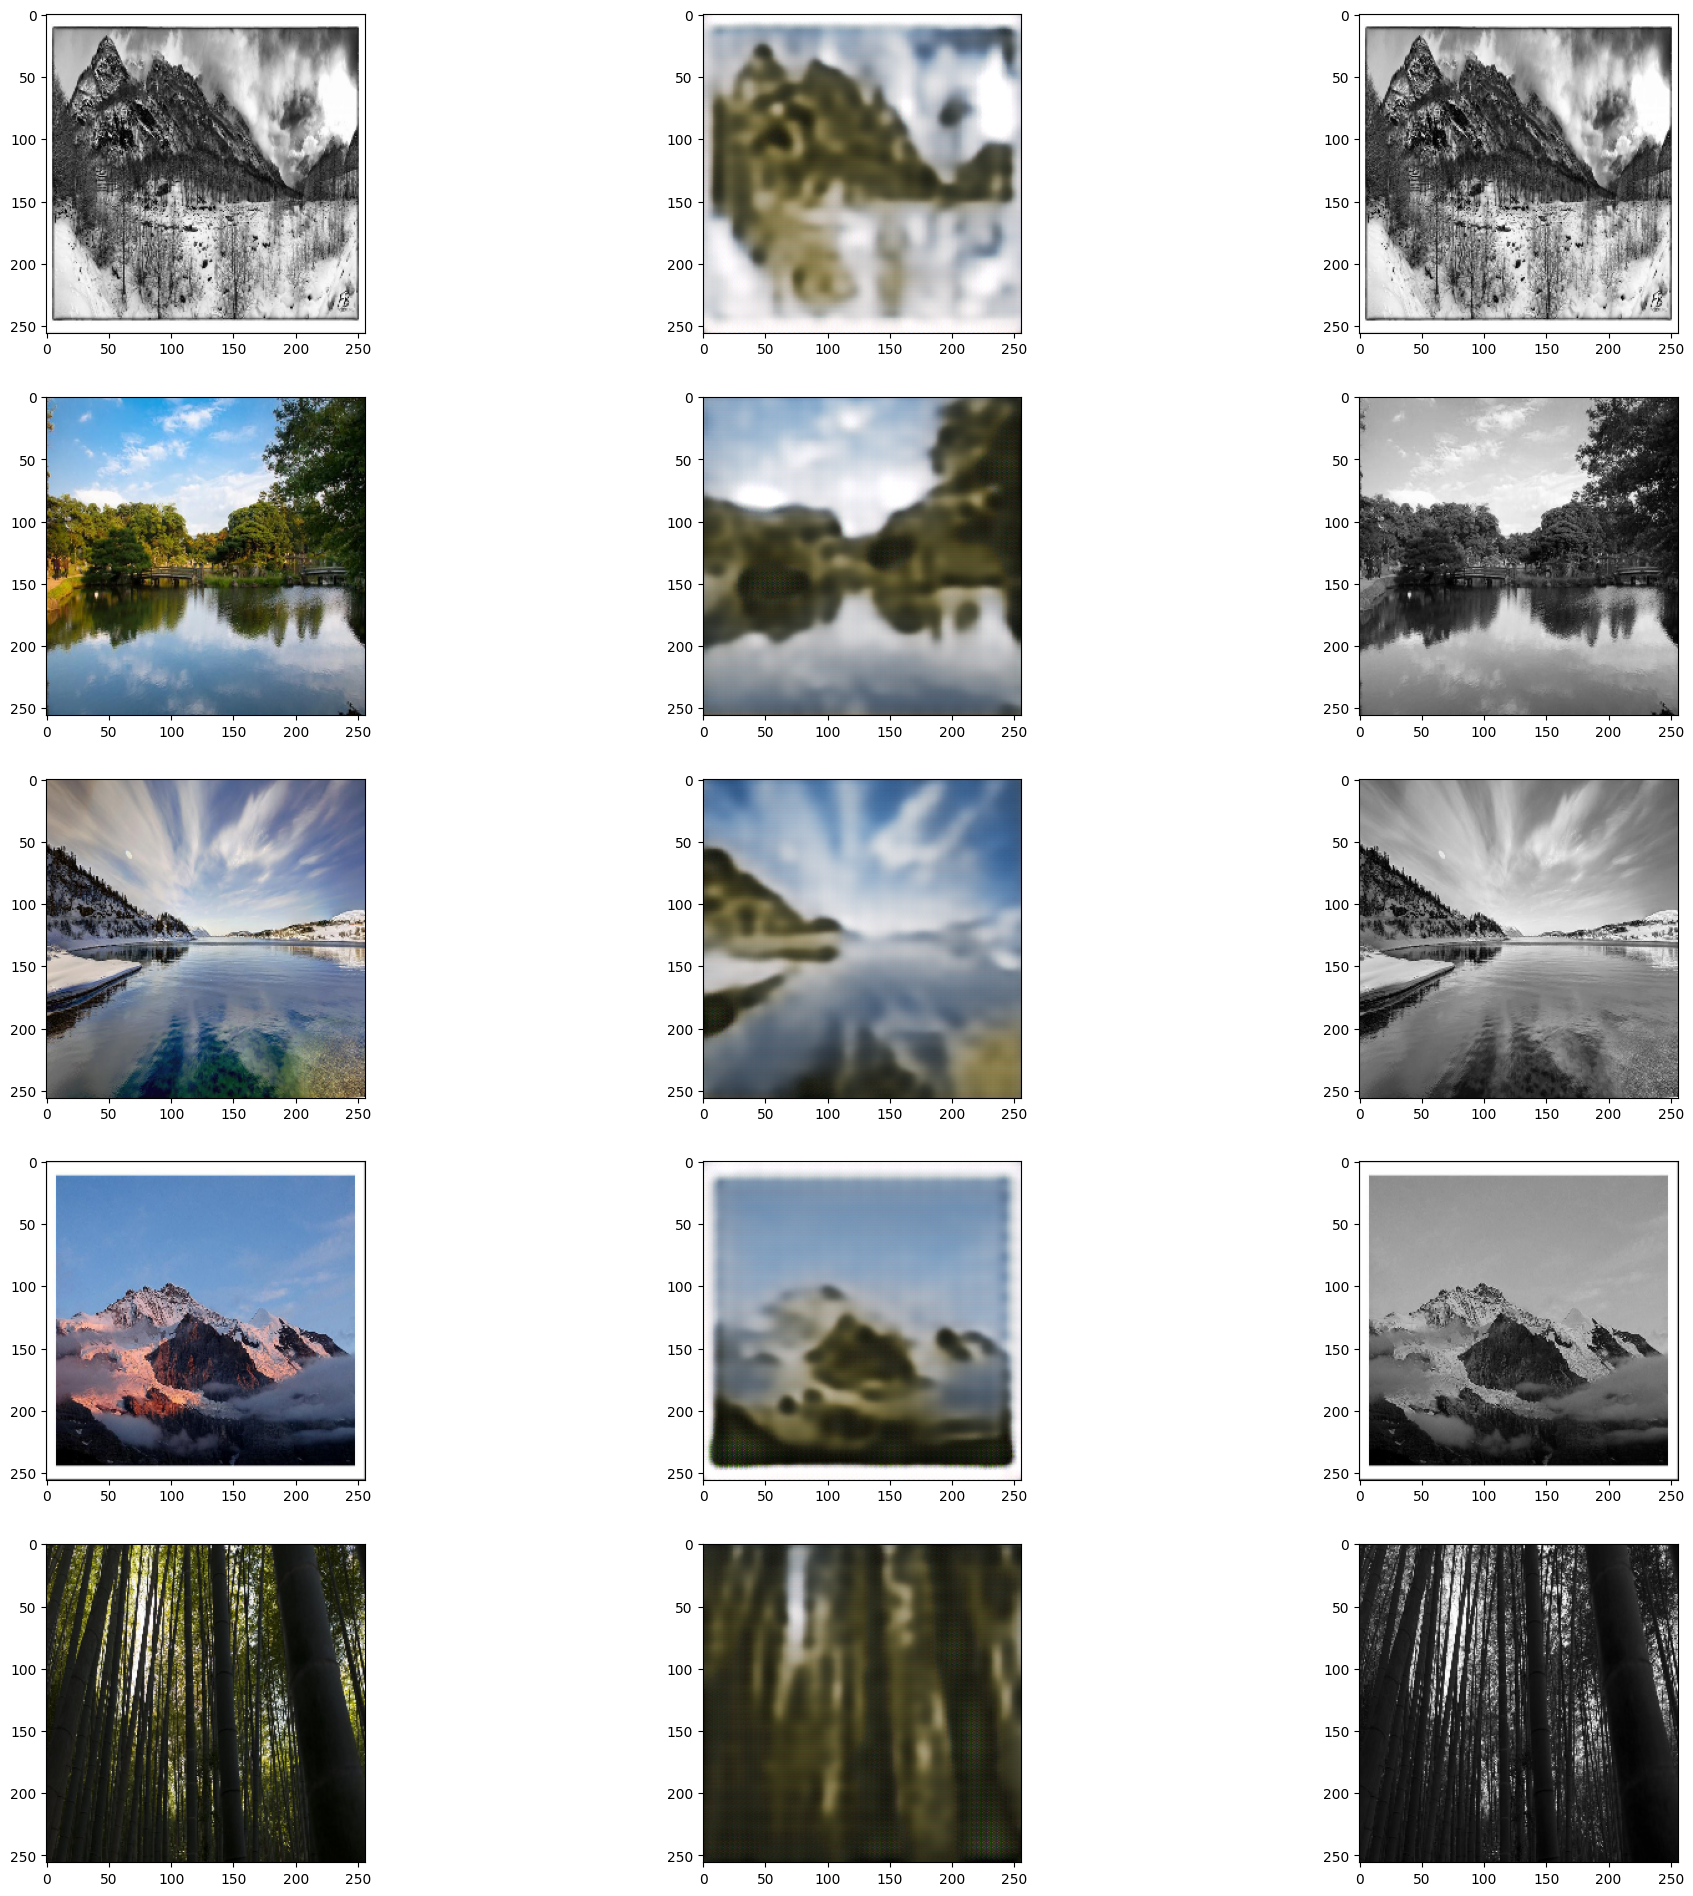

In [7]:
net.eval()
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[i+80]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy().transpose((1,2,0))
  out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(out_image)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(gray,cmap='gray')

plt.show()